# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [51]:
import random
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [52]:
from pkg.cross_attention import NLBlockND

In [53]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '090601oci'  # Define your experiment name to save models and results
exp = 't'

In [54]:
max_value = 2.5
min_value = -2.0

In [55]:
cls_w = 0.6

In [56]:
batch_size = 64

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(105)

## Load prep-processed data

In [57]:
X_train_t = torch.load(f'data/X_train_{exp}.pt')
y_train_t = torch.load(f'data/y_train_{exp}.pt')

X_val_t = torch.load(f'data/X_val_{exp}.pt')
y_val_t = torch.load(f'data/y_val_{exp}.pt')

X_test_t = torch.load(f'data/X_test_{exp}.pt')
y_test_t = torch.load(f'data/y_test_{exp}.pt')

In [58]:
dataset_train = Data.TensorDataset(X_train_t, y_train_t)
dataset_val = Data.TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle=True, pin_memory=True)

# Network

In [59]:
class Hierarchy(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
    )
      
    self.cls1 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )
    self.cls2 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )
    self.cls31 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
    )
    self.cls32 = nn.Sequential (
      nn.Linear(128, 3),
      nn.Sigmoid(),
    )

    self.reg1 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
    )
    self.cross_attn = nn.Sequential(
      NLBlockND(in_channels=128, dimension=2, bn_layer=False),
    )
    self.reg2 = nn.Sequential (
      nn.Linear(128, 1),
    )

    self.recon = nn.Sequential (
      nn.Linear(32, 128),
      nn.ReLU(),
      nn.Linear(128, input_size),
    )

  def forward(self, x):
    '''
      Forward pass
    '''
    feature = self.encoder(x)
    classification1 = self.cls1(feature)
    mask_cloudy = torch.where(classification1<=0.5, 1, 0)
    x_cloudy =  feature * mask_cloudy
    classification2 = self.cls2(x_cloudy)
    class3_feature = self.cls31(x_cloudy)
    classification3 = self.cls32(class3_feature)
    regression_feature = self.reg1(x_cloudy)
    attn_feature = self.cross_attn((regression_feature, class3_feature))
    regression = self.reg2(attn_feature)
    reconstruction = self.recon(feature)

    return reconstruction, classification1, classification2, classification3, mask_cloudy, regression

In [60]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# Optimization

In [76]:
# Initialize the MLP
model = Hierarchy(input_size=X_train_t.shape[1])
  
# Define the loss function and optimizer
loss_recon = nn.L1Loss()
loss_cls = nn.BCELoss()
loss_cls3 = nn.CrossEntropyLoss()
loss_reg = nn.L1Loss() # Pay attention to the threshold between cloud and non-cloud pxiels # add penalty to -1.5
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
# Run the training loop
train_loss_all = []
valid_loss_all = []
train_loss_cls1 = []
train_loss_cls2 = []
train_loss_cls3 = []
train_loss_reg = []
valid_loss_cls1 = []
valid_loss_cls2 = []
valid_loss_cls3 = []
valid_loss_reg = []

# Select model based on validation loss
valid_loss_min = 10.0

file = open("results/{}oci_log.txt".format(expname),"w")
early_stopping = EarlyStopping(tolerance=50, min_delta=0)

for epoch in range(550): 
  
  # Set current loss value
  train_loss = 0.0
  train_cls1 = 0.0
  train_cls2 = 0.0
  train_cls3 = 0.0
  train_reg = 0.0

  valid_loss = 0.0
  valid_cls1 = 0.0
  valid_cls2 = 0.0
  valid_cls3 = 0.0
  valid_reg = 0.0

  train_num = 0
  valid_num = 0
  
  # Iterate over the DataLoader for training data
  for step, (b_x,b_y) in enumerate(train_loader):
    mask = []
    # Get predictions
    recon, output_cls1, output_cls2, output_cls3, cloud_mask, output_reg = model(b_x)
    output_reg = output_reg*(max_value-min_value)+min_value
    cloud_n = torch.sum(cloud_mask)
    minibatch_n = output_cls1.shape[0]

    # Get ground truth values
    ground_truth_cls1 = torch.reshape(b_y[:,0], [-1,1]) # Cloud-free = 1, Cloudy = 0
    ground_truth_cls2 = torch.reshape(b_y[:,1], [-1,1]) # Liquid = 1, Ice = 0
    ground_truth_reg = torch.reshape(b_y[:,3], [-1,1])
    ground_truth_reg = ground_truth_reg*(max_value-min_value)+min_value
    cls3_1 = torch.where((ground_truth_reg<0)&(ground_truth_reg>-2), 1., 0.)
    cls3_2 = torch.where((ground_truth_reg>=0)&(ground_truth_reg<1), 1., 0.)
    cls3_3 = torch.where((ground_truth_reg>=1)&(ground_truth_reg<=2.5), 1., 0.)
    ground_truth_cls3 = torch.concatenate((cls3_1, cls3_2, cls3_3), 1)
    ground_truth_cls3 = ground_truth_cls3.float()

    '''
      Loss function
      L_cls: Cross Entropy loss of all predictions
      L_reg: masked regression loss of cloudy pixels 
    '''
    l_recon = loss_recon(recon, b_x)
    l_cls1 = loss_cls(output_cls1, ground_truth_cls1)
    l_cls2 = loss_cls(output_cls2, ground_truth_cls2)*minibatch_n/cloud_n
    l_cls3 = loss_cls3(output_cls3, ground_truth_cls3)*minibatch_n/cloud_n
    l_reg = loss_reg(output_reg, ground_truth_reg)*minibatch_n/cloud_n

    # Compute L1 loss component
    l1_weight = 0.0002
    l1_parameters = []
    for parameter in model.parameters():
      l1_parameters.append(parameter.view(-1))
    l1 = l1_weight*torch.abs(torch.cat((l1_parameters))).sum()

    loss = 3*l_recon + cls_w * (l_cls1 + l_cls2 + l_cls3) + (1-cls_w)*l_reg + 0.5*l1

    l_cls1.requires_grad_(True)
    l_cls2.requires_grad_(True)
    l_cls3.requires_grad_(True)
    l_reg.requires_grad_(True)
    file.write(f'Train recon Loss: {l_recon:.3f}, Train CLS Loss 1: {l_cls1:.3f}, Train CLS Loss 2: {l_cls2:.3f}, Train CLS Loss 3: {l_cls3:.3f}, Train REG Loss: {l_reg:.3f}\n') 

    optimizer.zero_grad
    loss.backward()
    optimizer.step()

    train_loss +=loss.item() * b_x.size(0)
    train_num += b_x.size(0)
    train_cls1 += l_cls1.item() * b_x.size(0)
    train_cls2 += l_cls2.item() * b_x.size(0)
    train_cls3 += l_cls3.item() * b_x.size(0)
    train_reg += l_reg.item() * b_x.size(0)
  train_loss_all.append(train_loss / train_num)
  train_loss_cls1.append(train_cls1 / train_num)
  train_loss_cls2.append(train_cls2 / train_num)
  train_loss_cls3.append(train_cls3 / train_num)
  train_loss_reg.append(train_reg / train_num)

  for setp, (c_x, c_y) in enumerate(validate_loader):
    mask = []
    # Get predictions
    recon_valid, output_cls1_valid, output_cls2_valid, output_cls3_valid, cloud_mask_valid, output_reg_valid = model(c_x)
    output_reg_valid = output_reg_valid*(max_value-min_value)+min_value
    cloud_n = torch.sum(cloud_mask_valid)
    minibatch_n = output_cls1_valid.shape[0]

    # Get ground truth values
    ground_truth_cls1_valid = torch.reshape(c_y[:,0], [-1,1])
    ground_truth_cls2_valid = torch.reshape(c_y[:,1], [-1,1])
    ground_truth_reg_valid = torch.reshape(c_y[:,3], [-1,1])
    ground_truth_reg_valid = ground_truth_reg_valid*(max_value-min_value)+min_value
    cls3_1_v = torch.where((ground_truth_reg_valid<0), 1., 0.)
    cls3_2_v = torch.where((ground_truth_reg_valid>=0)&(ground_truth_reg_valid<1), 1., 0.)
    cls3_3_v = torch.where((ground_truth_reg_valid>=1), 1., 0.)
    ground_truth_cls3_v = torch.concatenate((cls3_1_v, cls3_2_v, cls3_3_v), 1)

    l_recon_v = loss_recon(recon_valid, c_x)
    l_cls1_v = loss_cls(output_cls1_valid, ground_truth_cls1_valid)
    l_cls2_v = loss_cls(output_cls2_valid, ground_truth_cls2_valid)*minibatch_n/cloud_n
    l_cls3_v = loss_cls3(output_cls3_valid, ground_truth_cls3_v)*minibatch_n/cloud_n
    l_reg_v = loss_reg(output_reg_valid, ground_truth_reg_valid)*minibatch_n/cloud_n
    file.write(f'Valid CLS Loss 1: {l_cls1_v:.3f}, Valid CLS Loss 2: {l_cls2_v:.3f}, Valid REG Loss: {l_reg_v:.3f}\n') 
    
    loss_v = 3*l_recon_v + cls_w * (l_cls1_v + l_cls2_v + l_cls3_v) + (1-cls_w)*l_reg_v + 0.5*l1

    valid_loss +=loss_v.item() * c_x.size(0)
    valid_num += c_x.size(0)
    valid_cls1 += l_cls1_v.item() * c_x.size(0)
    valid_cls2 += l_cls2_v.item() * c_x.size(0)
    valid_cls3 += l_cls3_v.item() * c_x.size(0)
    valid_reg += l_reg_v.item() * c_x.size(0)
  valid_loss_all.append(valid_loss / valid_num)
  valid_loss_cls1.append(valid_cls1 / valid_num)
  valid_loss_cls2.append(valid_cls2 / valid_num)
  valid_loss_cls3.append(valid_cls3 / valid_num)
  valid_loss_reg.append(valid_reg / valid_num)

  print(f'Epoch {epoch+1} - Train Loss: {(train_loss / train_num):.3f}, Valid Loss: {(valid_loss / valid_num):.3f}')  
  file.write(f'Epoch {epoch+1} - Train Loss: {(train_loss / train_num):.3f}, Valid Loss: {(valid_loss / valid_num):.3f}, l1 Loss: {l1:.3f} \n')

  if (valid_loss / valid_num) <= valid_loss_min:
    valid_loss_min = (valid_loss / valid_num)
    torch.save(model.state_dict(), './models/{}_min_valid_loss.pth'.format(expname))

  # early_stopping((train_loss / train_num), (valid_loss / valid_num))
  # if early_stopping.early_stop:
  #   print("Early stopping at epoch:", epoch)
  #   break
  
file.write(f'Minimum Valid Loss: Epoch {epoch} - {valid_loss_min:.3f} \n')
file.close() #to change file access modes
print('Training process has finished.')

In [ ]:
valid_loss_min

In [69]:
PATH = './models/{}_oci.pth'.format(expname)
torch.save(model.state_dict(), PATH)

# Training Loss Plot

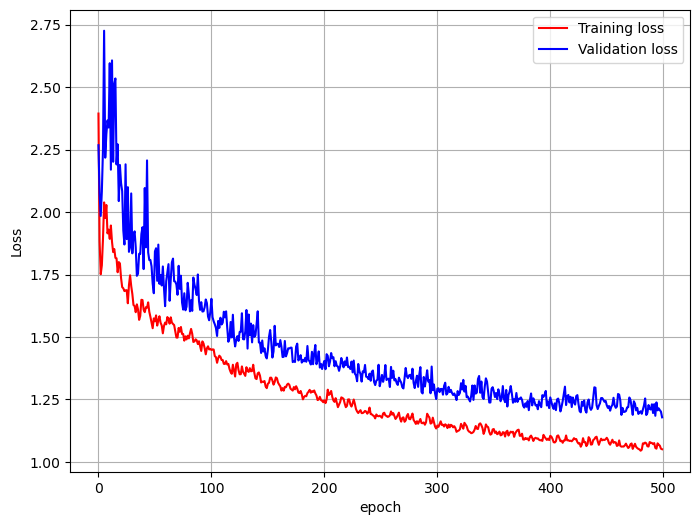

In [68]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_all, 'r-', label = 'Training loss')
plt.plot(valid_loss_all, 'b-', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('./results/{}_loss.png'.format(expname))
plt.show()

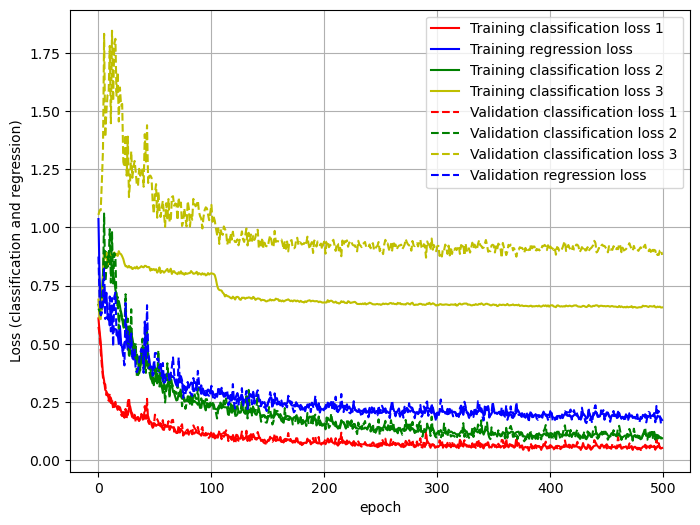

In [70]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_cls1, 'r-', label = 'Training classification loss 1')
plt.plot(train_loss_reg, 'b-', label = 'Training regression loss')
plt.plot(train_loss_cls2, 'g-', label = 'Training classification loss 2')
plt.plot(train_loss_cls3, 'y-', label = 'Training classification loss 3')
plt.plot(valid_loss_cls1, 'r--', label = 'Validation classification loss 1')
plt.plot(valid_loss_cls2, 'g--', label = 'Validation classification loss 2')
plt.plot(valid_loss_cls3, 'y--', label = 'Validation classification loss 3')
plt.plot(valid_loss_reg, 'b--', label = 'Validation regression loss')

plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss (classification and regression)')
plt.savefig('./results/{}_loss_detail.png'.format(expname))
plt.show()